# Architecture of an RNN

| Hyperparameter/Layer type | What does it do?                                                                       | Typical Values                                                                                |
|---------------------------|----------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|
| input texts(s)            | Takes in target sequence                                                               | `input_shape = [batch_size, embedding_size]` or `[batch_size, sequence_shape]`                |
| Text Vectorization layer  | Maps input sequence to number                                                          | Multiple, can create with `tf.keras.layers.experimental.preprocessing.TextVectorization`      |
| Embeddings                | Turns mapping of text vectors to embedding matrix (representation of how words relate) | Multiple, can create with `tf.keras.layers.Embedding`                                         |
| RNN cell(s)               | Finds patterns in sequences                                                            | `SimpleRNN, LSTM, GRU`                                                                        |
| Hidden activation         | Adds non-linearity to learned features (non-straight lines)                            | Usually Tanh (hyperbolic tangent) (`tf.keras.activation.tanh`)                                |
| Pooling layer             | Reduces the dimensionality of learned sequence features (usually for Conv1D models)    | Average (`tf.keras.layers.GlobalAveragePooling1D`) or Max (`tf.keras.layers.GlobalMaxPool1D`) |
| Fully connected layer     | Further refines learned features from recurrent layers                                 | `tf.keras.layers.Dense`                                                                       |
| Output layer              | Takes learned features and outputs them in shape of target labels                      | `output_shape = [number_of_classes]`                                                          |
| Output Activation         | Adds non-linearity to output layer                                                     | `tf.keras.activation.sigmoid` (binary classification) or `tf.keras.activation.softmax`        |


In [142]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Get a Text Dataset
The dataset we'regoing to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster).

## Visualizing a text dataset

In [2]:
train_df = pd.read_csv('Data/nlp_getting_started/train.csv')
test_df = pd.read_csv('Data/nlp_getting_started/test.csv')

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [5]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
# How many examples of each class?
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [7]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [8]:
# Let's visuallize some random training examples
import random
random_index = random.randint(0, len(train_df)-5)# Create random indexes not higher than the total number of samples 
for row in train_df_shuffled[['text','target']][random_index: random_index+5].itertuples():
    _, text, target = row
    print(f"Target: {target}", "{real disaster}" if target > 0 else "(not real disaster)")
    print(f"Text:\n{text}\n")
    print("---\n")

Target: 1 {real disaster}
Text:
And please don't flood poor @RobertBEnglund's mentions. He's put in his work!

---

Target: 1 {real disaster}
Text:
West Valley I405 N / Us101 S I405 N Con **Trfc Collision-Unkn Inj** http://t.co/jS9EhP88wQ

---

Target: 0 (not real disaster)
Text:
@b24fowler I see that! Crazy how this line blew up.

---

Target: 0 (not real disaster)
Text:
@daewony0406 alright now I'm gonna crash I'm so exhausted

---

Target: 1 {real disaster}
Text:
Investigators say a fatal Virgin Galactic spaceship crash last year was caused by structural failure after the... http://t.co/FPrt7NwrOt

---



### Split data into training and validation sets

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                           train_df_shuffled['target'].to_numpy(),
                                                                           test_size = 0.1 ,# use 10% of training data for validation split
                                                                           random_state=42)

In [11]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [12]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

**Tokenization** 
- A straight mapping from word or character or sub-word to a numerical value. There are three main levels of tokenization:
1. Using **word-level tokenization** with the sentence "I love TensorFlow" might result in "I" being 0, "love" being 1 and "TensorFlow" being 2. In this case, every word in a sequence considered a single **token**.
2. **Character-level tokenization**, such as converting the letters A-Z to values 1-26. In this case, every character in a sequence considered a single **token**.
3. **Sub-word tokenization** is in between word-level and character-level tokenization. It involves breaking invidual words into smaller parts and then converting those smaller parts into numbers. For example, "my favourite food is pineapple pizza" might become "my, fav, avour, rite, fo, oo, od, is, pin, ine, app, le, piz, za". After doing this, these sub-words would then be mapped to a numerical value. In this case, every word could be considered multiple **tokens**.

**Embeddings** 
- An embedding is a representation of natural language which can be learned. Representation comes in the form of a **feature vector**. For example, the word "dance" could be represented by the 5-dimensional vector [-0.8547, 0.4559, -0.3332, 0.9877, 0.1112]. It's important to note here, the size of the feature vector is tuneable. There are two ways to use embeddings:
1. **Create your own embedding** - Once your text has been turned into numbers (required for an embedding), you can put them through an embedding layer (such as tf.keras.layers.Embedding) and an embedding representation will be learned during model training.
2. **Reuse a pre-learned embedding** - Many pre-trained embeddings exist online. These pre-trained embeddings have often been learned on large corpuses of text (such as all of Wikipedia) and thus have a good underlying representation of natural language. You can use a pre-trained embedding to initialize your model and fine-tune it to your own specific task.

### Text Vectorization (tokenization)

In [13]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [14]:
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary
                                   standardize="lower_and_strip_punctuation",
                                   split="whitespace",
                                   ngrams=None, # Create groups of n-words
                                   output_mode='int', # how to map tokens to numbers
                                   output_sequence_length=None, # how long do you want your sequence to be?
                                   )

In [15]:
len(train_sentences[0].split())

7

In [16]:
round(sum([len(i.split()) for i in train_sentences]))

102087

In [17]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [18]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequence will be (e.g. how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                      output_sequence_length=max_length)

In [19]:
# Fit the text vecotrizer to the training text
text_vectorizer.adapt(train_sentences)

In [20]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int64)>

In [21]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
     \n\nVectorized version: ")
text_vectorizer([random_sentence])

Original text:
 mentions of 'theatre +shooting' on Twitter spike 30min prior to $ckec collapse http://t.co/uuBOvy9GQI     

Vectorized version: 


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[2050,    6, 1951,  617,   11,  382, 8223,    1, 2782,    5,    1,
         155,    1,    0,    0]], dtype=int64)>

In [22]:
# Get the unique words in vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in the training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 Most common words: {top_5_words}")
print(f"5 Least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 Most common words: ['', '[UNK]', 'the', 'a', 'in']
5 Least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using Embeddin Layer

The paramter we care most about for our embedding layer:
- `input_dim` = the size of our vocabulary
- `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
- `input_length` = length of the sequences being passed to the embedding layer

In [23]:
from tensorflow.keras import layers

In [24]:
max_vocab_length, max_length

(10000, 15)

In [25]:
embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                            output_dim=128, # output shape
                            input_length=max_length # how long is each input
                            ) 
embedding

In [26]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
    \nEmbedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 Harshness Follows Us a
Better Day
by Sarah C
Racing thoughts with screaming sirens
Pacing back and forth for... http://t.co/ProNtOuo91    
Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.03090152, -0.03370758,  0.00092022, ..., -0.00383916,
          0.01627164, -0.01622596],
        [ 0.04146374,  0.0239217 ,  0.04596612, ..., -0.03964501,
          0.02929964, -0.00799692],
        [-0.02877517,  0.02431269, -0.00027614, ...,  0.04852494,
         -0.01090112,  0.0163198 ],
        ...,
        [ 0.00623779,  0.03105433, -0.01683553, ...,  0.04877551,
         -0.02308056, -0.04875856],
        [-0.03341652, -0.04855214, -0.0485457 , ..., -0.0147303 ,
          0.0390857 ,  0.02931849],
        [-0.03090152, -0.03370758,  0.00092022, ..., -0.00383916,
          0.01627164, -0.01622596]]], dtype=float32)>

In [27]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.03090152, -0.03370758,  0.00092022, -0.0086095 , -0.03804547,
        -0.04493318,  0.02411605,  0.03888411, -0.0249571 , -0.0306203 ,
         0.03890071,  0.0379152 , -0.0357147 , -0.03568275,  0.00411243,
         0.04556698,  0.02997614, -0.03850775, -0.00965884, -0.03599235,
        -0.01208848,  0.03207758,  0.01139784, -0.02447828, -0.04857664,
         0.01688609, -0.02861773, -0.0019627 ,  0.04603562, -0.00577309,
         0.04666367, -0.02760726, -0.01030301, -0.01411235, -0.02219879,
         0.0304342 , -0.04332565,  0.01761342, -0.03292984, -0.03531207,
         0.00359563, -0.03467093,  0.00055759,  0.03771878, -0.01229365,
        -0.01313975, -0.02315599,  0.01225804, -0.01941505, -0.03976064,
        -0.00790075,  0.00418667,  0.00695854, -0.00357392,  0.03846038,
         0.00647309, -0.03798984,  0.03680476,  0.01285467, -0.03841024,
        -0.02369889,  0.00769509,  0.02900166,  0.02894132,  0.01656932,
  

## Modelling a text dataset (running a series of experiments)

We'll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline)
* Model 1: Feed-Forword neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convulational Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (using tranfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

## Model 0: Baseline

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using TF-IDF formula to convert our words to numbers.

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [29]:
# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # Converts words to numbers using tfidf
    ("clf", MultinomialNB()) # Model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [30]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [31]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype=int64)

### Creating an evluation function for our model experiments

In [32]:
# Functions to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1-score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                    "precision": model_precision,
                    "recall": model_recall,
                    "f1-score": model_f1}
    return model_results

In [33]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                    y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1-score': 0.7862189758049549}

## Model 1: A simple dense model

In [34]:
# Create a tensorboard vallback (need to create a new one for each model)

# Create a directory to save Tensorboard logs
SAVE_DIR = "model_logs"

In [35]:
# Buils model with the Functional API
inputs = layers.Input(shape=(1,), dtype=tf.string) #inputs are 1-dimensional strings
x = text_vectorizer(inputs) # Turn the input texts into numbers
x = embedding(x) # create an embedding of the numberized inputs
# x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x) # create the output layer, want binary outputs so use sigmoid activation function
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [36]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [37]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [38]:
# Fit the model
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                    experiment_name='model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20240110-213727
Epoch 1/5

215/215 [==============================] - 6s 15ms/step - loss: 0.6389 - accuracy: 0.6633 - val_loss: 0.5715 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4671 - accuracy: 0.8314 - val_loss: 0.4663 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3397 - accuracy: 0.8740 - val_loss: 0.4461 - val_accuracy: 0.7992
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2572 - accuracy: 0.9070 - val_loss: 0.4518 - val_accuracy: 0.7979
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1975 - accuracy: 0.9343 - val_loss: 0.4640 - val_accuracy: 0.7887


In [39]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4640 - accuracy: 0.7887


[0.46402522921562195, 0.7887139320373535]

In [40]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[0]

24/24 [==============================] - 0s 2ms/step


array([0.41438612], dtype=float32)

In [41]:
# Convert model prediction probabilites to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [42]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                   y_pred=model_1_preds)
model_1_results

{'accuracy': 78.87139107611549,
 'precision': 0.7943691525527891,
 'recall': 0.7887139107611548,
 'f1-score': 0.7855210885289512}

## Visualizing learned embeddings

In [43]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [44]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [45]:
# Get the weight matrix of embedding layer
# these are the numerical representations of each token in our training data, which have been learned for -5 epochs
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights.shape # same size as vocab size and embedding_dim (output_dim of our embedding layer)

(10000, 128)

In [46]:
# Create embedding files (we got this from TensorFlow's word embeddings documentation)
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The output from the previous step is fed as input to the current step.

## Model 2: LSTM

LSTM = Long Short Term Memory

Our structure of an RNN typically looks like this:

`input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (labbel probability)`

### LSTM: Key concepts

1. Maintain a **cell state**
2. USe **gates** to control the flow of information
   * **Forget** gate gets rid of irrelevant information
   * **Store** relevent information from current input
   * Selectively **update** cell state
   * **Output** gate returns a filtered version of the cell state

And to make sure we're not getting reusing trained embeddings (this would involve data leakage between models, leading to an uneven comparison later on), we'll create another embedding layer `(model_2_embedding)` for our model.The `text_vextorizer` layer can vev reused since it doesn't get updated during training

> 🔑 **NOTE**: The reason we use a new embedding layer for each model is since the embedding layer is a learned representation of words (as numbers), if we were to use the same embedding layer `(embedding_1)` for each model, we'd be mixing what one model learned with the next. And because we want to compare our models later on, starting them with their own embedding layer each time is a better idea.

In [47]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                    output_dim=128,
                                    embeddings_initializer='uniform',
                                    input_length=max_length,
                                    name="embedding_2")

# Create an LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True) # When you're stacking RNN cells together, you need to set return_sequence=True
x = layers.LSTM(64)(x)
print(x.shape)
# x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [48]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [49]:
# compile the model
model_2.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [50]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                             train_labels,
                             epochs=5,
                             validation_data=(val_sentences,val_labels),
                             callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20240110-213746
Epoch 1/5
215/215 [==============================] - 7s 22ms/step - loss: 0.5079 - accuracy: 0.7454 - val_loss: 0.4557 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.3145 - accuracy: 0.8727 - val_loss: 0.5182 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.2170 - accuracy: 0.9168 - val_loss: 0.5864 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.1519 - accuracy: 0.9476 - val_loss: 0.5895 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.1051 - accuracy: 0.9616 - val_loss: 0.8520 - val_accuracy: 0.7612


In [51]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 5ms/step


array([[0.00364079],
       [0.71935016],
       [0.9991115 ],
       [0.06534643],
       [0.00171622],
       [0.9993588 ],
       [0.70030916],
       [0.99959844],
       [0.9993064 ],
       [0.24501963]], dtype=float32)

In [52]:
# Convert model_2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [53]:
# Calculate model_2 results
model_2_results = calculate_results(y_true=val_labels,
                                   y_pred=model_2_preds)
model_2_results

{'accuracy': 76.11548556430446,
 'precision': 0.7627664723727715,
 'recall': 0.7611548556430446,
 'f1-score': 0.7588524417705016}

## Model 3: GRU

The GRU cell has similar features to an LSTM cell but has less paramters

In [54]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                    output_dim=128,
                                    input_length=max_length,
                                    name="embedding_3")

# Build an RNN using GRU cell
inputs = tf.keras.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
x = layers.GRU(64)(x)
# x = layers.GRU(64, return_sequences=True)(x) # if we want to stack recurrent layers on top of each other, you need to set return_sequence=True
# print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x)
# print(x.shape)
# x = layers.GRU(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [55]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [56]:
# Compile the model
model_3.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [57]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                             train_labels,
                             validation_data=(val_sentences, val_labels),
                             epochs=5,
                             callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20240110-213810
Epoch 1/5
215/215 [==============================] - 7s 23ms/step - loss: 0.5308 - accuracy: 0.7228 - val_loss: 0.4558 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3198 - accuracy: 0.8672 - val_loss: 0.4908 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.2151 - accuracy: 0.9178 - val_loss: 0.5698 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.1500 - accuracy: 0.9491 - val_loss: 0.6460 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.1128 - accuracy: 0.9610 - val_loss: 0.6163 - val_accuracy: 0.7690


In [58]:
# Make predictions
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 1s 5ms/step


array([[0.40496296],
       [0.91693306],
       [0.99756384],
       [0.1786995 ],
       [0.00913915],
       [0.99170476],
       [0.7482027 ],
       [0.99735737],
       [0.99536693],
       [0.34713897]], dtype=float32)

In [59]:
# Convert model_3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [60]:
# Calculate model_3 results
model_3_results = calculate_results(y_true=val_labels,
                                   y_pred=model_3_preds)
model_3_results

{'accuracy': 76.9028871391076,
 'precision': 0.7687652149942675,
 'recall': 0.7690288713910761,
 'f1-score': 0.7682483510472345}

## Model 4: Birdirectional RNN

In [63]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                    input_length=max_length,
                                    output_dim=128,
                                    name="embedding_4",
                                    embeddings_initializer="uniform")

# build a Birdirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs =  layers.Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [64]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

In [65]:
# Compile the model
model_4.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [66]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                             train_labels,
                             validation_data=(val_sentences, val_labels),
                             epochs=5,
                             callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20240110-231443
Epoch 1/5
215/215 [==============================] - 14s 32ms/step - loss: 0.5062 - accuracy: 0.7485 - val_loss: 0.4594 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 5s 24ms/step - loss: 0.3113 - accuracy: 0.8753 - val_loss: 0.5389 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 5s 25ms/step - loss: 0.2092 - accuracy: 0.9215 - val_loss: 0.5745 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 5s 25ms/step - loss: 0.1413 - accuracy: 0.9529 - val_loss: 0.6528 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 6s 26ms/step - loss: 0.0987 - accuracy: 0.9653 - val_loss: 0.6831 - val_accuracy: 0.7703


In [67]:
# Make predictions
model_4_preds_probs = model_4.predict(val_sentences)
model_4_preds_probs[:10]

24/24 [==============================] - 2s 8ms/step


array([[0.01921569],
       [0.81667835],
       [0.99922067],
       [0.08623891],
       [0.00286197],
       [0.995832  ],
       [0.8114718 ],
       [0.9996013 ],
       [0.999385  ],
       [0.19528708]], dtype=float32)

In [68]:
model_4_preds = tf.squeeze(tf.round(model_4_preds_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [70]:
# Calculate the results of our bidirectional model
model_4_results = calculate_results(y_true=val_labels,
                                   y_pred=model_4_preds)
model_4_results

{'accuracy': 77.03412073490814,
 'precision': 0.7726339681635592,
 'recall': 0.7703412073490814,
 'f1-score': 0.7679241301282296}

## Convolution Neural Network for Text

### Model 5: Conv1D

In [72]:
# Test out our embedding layer, Conv1D layer and max pooling
embedding_test = embedding(text_vectorizer(['this is a test sequence'])) # turn target sequence into embedding
conv_1d = layers.Conv1D(filters=32,
                       kernel_size=5, # this is also referd to as an input ngram of 5 (meaning it looks at 5 words at a time)
                       activation='relu',
                       padding='same') # default = "valid", the output is smaller than the input shape, "same" means output is same shape as input

conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most important feature" or "get the feature with the highest value"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 32]), TensorShape([1, 32]))

In [76]:
# embedding_test

In [77]:
# conv_1d_output

In [78]:
# max_pool_output

In [80]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                    input_length=max_length,
                                    output_dim=128,
                                    name="embedding_5")

# Create 1-dimensional convolutional layer to model sequence
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile the model
model_5.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_3 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_4 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_5 (Dense)             (None, 1)              

In [81]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                             train_labels,
                             validation_data=(val_sentences, val_labels),
                             epochs=5,
                             callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20240111-212144
Epoch 1/5
215/215 [==============================] - 6s 19ms/step - loss: 0.5454 - accuracy: 0.7289 - val_loss: 0.4605 - val_accuracy: 0.7940
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3279 - accuracy: 0.8666 - val_loss: 0.4780 - val_accuracy: 0.7913
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.2035 - accuracy: 0.9248 - val_loss: 0.5491 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1285 - accuracy: 0.9577 - val_loss: 0.6270 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0914 - accuracy: 0.9691 - val_loss: 0.6827 - val_accuracy: 0.7887


In [82]:
model_5_preds_probs = model_5.predict(val_sentences)
model_5_preds_probs[:10]

24/24 [==============================] - 0s 5ms/step


array([[0.57653046],
       [0.84108776],
       [0.9999529 ],
       [0.0578444 ],
       [0.0075365 ],
       [0.9952683 ],
       [0.9701794 ],
       [0.9973623 ],
       [0.9997266 ],
       [0.08895043]], dtype=float32)

In [83]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_preds_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [84]:
# Evaluate model 5 results
model_5_results = calculate_results(y_true=val_labels,
                                   y_pred=model_5_preds)
model_5_results

{'accuracy': 78.87139107611549,
 'precision': 0.7939119079827037,
 'recall': 0.7887139107611548,
 'f1-score': 0.7856693843184869}

>🔑 **Note:** An **Encoder** is the name for a model which converts raw data such as text into numerical representation (feature vector), a **decoder** converts the numerical representation to a desired output

## model 6: TensorFlow Hub Pretrained Sentence Encoder

In [86]:
import tensorflow_hub as hub
embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2")
embed_samples = embed([sample_sentence,
                      "When you can the universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195372  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [87]:
embed_samples[0].shape

TensorShape([512])

In [88]:
# Create a Keras layer using USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name = "USE")

In [98]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name="model_6_USE")

# Compile the model
model_6.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_8 (Dense)             (None, 64)                32832     
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [99]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                             train_labels,
                             validation_data=(val_sentences, val_labels),
                             epochs=5,
                             callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20240112-003959
Epoch 1/5
215/215 [==============================] - 5s 11ms/step - loss: 0.5037 - accuracy: 0.7802 - val_loss: 0.4486 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.4150 - accuracy: 0.8137 - val_loss: 0.4376 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.4005 - accuracy: 0.8216 - val_loss: 0.4334 - val_accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3936 - accuracy: 0.8250 - val_loss: 0.4286 - val_accuracy: 0.8097
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3876 - accuracy: 0.8282 - val_loss: 0.4299 - val_accuracy: 0.8150


In [100]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 7ms/step


array([[0.15224092],
       [0.7450482 ],
       [0.98752743],
       [0.20383276],
       [0.7129781 ],
       [0.6740718 ],
       [0.9796668 ],
       [0.97549736],
       [0.92403775],
       [0.09168851]], dtype=float32)

In [101]:
# Convert predictions probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [102]:
# Calculate model 6 performace metris
model_6_results = calculate_results(y_true=val_labels,
                                   y_pred=model_6_preds)
model_6_results

{'accuracy': 81.49606299212599,
 'precision': 0.8172549323109193,
 'recall': 0.8149606299212598,
 'f1-score': 0.8134357776936025}

## Model 7: TF Hub Pretrained USE but with 10% of training data

In [117]:
# NOTE: Making data splits like this below leads to data leakage (model 7 trained on 10% data, outperforms model 6 trained on 100% data)
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET 
# Create subsets of 10% of training data
# train_10_percent = train_df_shuffled[['text', 'target']].sample(frac=0.1, random_state=42)
# Train_10_percent.head(), len(train_10_percent)
# train_sentences_10_percent = train_10_percent['text'].to_list()
# train_labels_10_percent = train_10_percent['target'].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

In [131]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [132]:
# Check the number of each label in the updated training subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
Name: count, dtype: int64

> To recreate a model the same as a previous model you've created you can use the `tf.keras.models.clone_model()` method

In [133]:
# Let's build a model the same as model_6
# model_7 = tf.keras.models.clone_model(model_6)
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name="model_7_USE")

# Compile the model
model_7.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_12 (Dense)            (None, 64)                32832     
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [134]:
# Fit the model to the 10% training data 
model_7_history = model_7.fit(train_sentences_10_percent,
                             train_labels_10_percent,
                             epochs=5,
                             validation_data=(val_sentences,val_labels),
                             callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   "tf_hub_sentence_encoder_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20240112-013234
Epoch 1/5
22/22 [==============================] - 2s 40ms/step - loss: 0.6759 - accuracy: 0.6555 - val_loss: 0.6537 - val_accuracy: 0.7323
Epoch 2/5
22/22 [==============================] - 0s 16ms/step - loss: 0.6102 - accuracy: 0.8044 - val_loss: 0.5994 - val_accuracy: 0.7533
Epoch 3/5
22/22 [==============================] - 0s 16ms/step - loss: 0.5351 - accuracy: 0.8073 - val_loss: 0.5426 - val_accuracy: 0.7717
Epoch 4/5
22/22 [==============================] - 0s 16ms/step - loss: 0.4715 - accuracy: 0.8190 - val_loss: 0.5091 - val_accuracy: 0.7703
Epoch 5/5
22/22 [==============================] - 0s 17ms/step - loss: 0.4273 - accuracy: 0.8321 - val_loss: 0.4913 - val_accuracy: 0.7795


In [135]:
# Make predictionswith the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 6ms/step


array([[0.20283106],
       [0.5698388 ],
       [0.93173325],
       [0.3712831 ],
       [0.5343784 ],
       [0.6959632 ],
       [0.88990384],
       [0.8373216 ],
       [0.85186166],
       [0.15911609]], dtype=float32)

In [136]:
# Turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [137]:
# Calculate the model 7 predictions
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 77.95275590551181,
 'precision': 0.7808713829501961,
 'recall': 0.7795275590551181,
 'f1-score': 0.7777699173240801}

## Comparing the performace of each of our models

In [144]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                 "1_simple_dense": model_1_results,
                                 "2_LSTM": model_2_results,
                                 "3_GRU": model_3_results,
                                 "4_BiDirectional": model_4_results,
                                 "5_Conv1D": model_5_results,
                                 "6_tf_hub_use_encoder": model_6_results,
                                 "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1-score
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.871391,0.794369,0.788714,0.785521
2_LSTM,76.115486,0.762766,0.761155,0.758852
3_GRU,76.902887,0.768765,0.769029,0.768248
4_BiDirectional,77.034121,0.772634,0.770341,0.767924
5_Conv1D,78.871391,0.793912,0.788714,0.785669
6_tf_hub_use_encoder,81.496063,0.817255,0.814961,0.813436
7_tf_hub_use_encoder_10_percent,77.952756,0.780871,0.779528,0.777770


In [145]:
# Reduce the accuracy to the same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy']/100
all_model_results

,accuracy,precision,recall,f1-score
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.788714,0.794369,0.788714,0.785521
2_LSTM,0.761155,0.762766,0.761155,0.758852
3_GRU,0.769029,0.768765,0.769029,0.768248
4_BiDirectional,0.770341,0.772634,0.770341,0.767924
5_Conv1D,0.788714,0.793912,0.788714,0.785669
6_tf_hub_use_encoder,0.814961,0.817255,0.814961,0.813436
7_tf_hub_use_encoder_10_percent,0.779528,0.780871,0.779528,0.777770


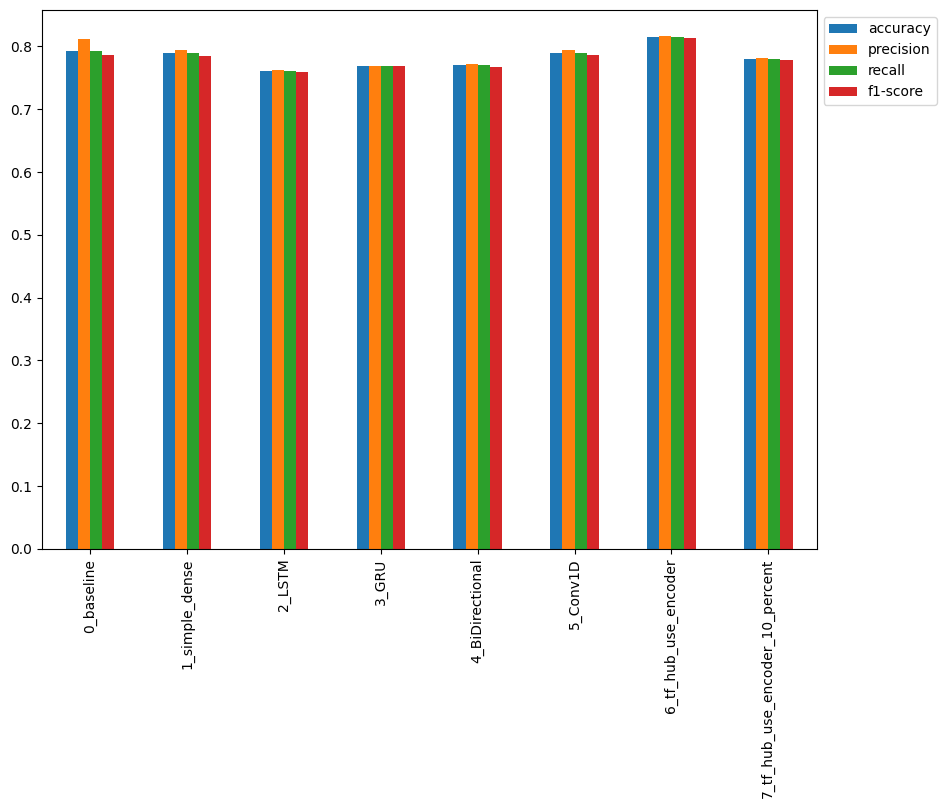

In [146]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

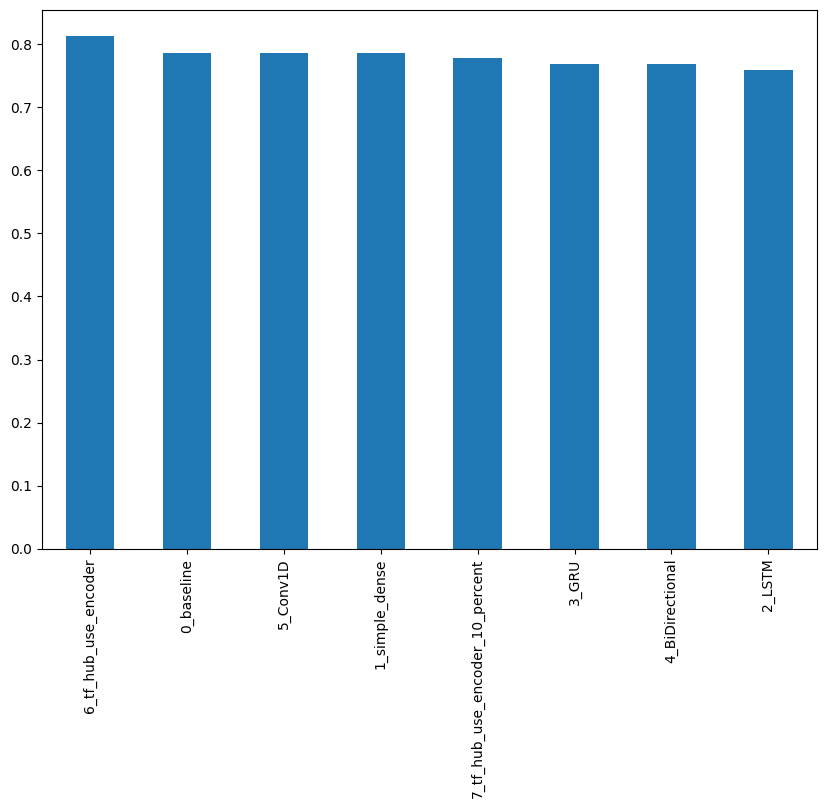

In [149]:
# Sort model results by f1-score
all_model_results.sort_values("f1-score", ascending=False)['f1-score'].plot(kind="bar", figsize=(10, 7));

## Saving and loading a trained model

There are two formats to save a model to in TensorFlow:
1. The HDF5 format
2. The `SavedModel` format (this is the default when using TensorFlow)

In [150]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

C:\Users\shrih\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [151]:
# Load model with custom Hub Layer (required H5 format)
Loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                           custom_objects={"KerasLayer": hub.KerasLayer})

In [152]:
# how does our loaded model perform?
Loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 19ms/step - loss: 0.4299 - accuracy: 0.8150


[0.42987561225891113, 0.8149606585502625]

In [153]:
model_6_results

{'accuracy': 81.49606299212599,
 'precision': 0.8172549323109193,
 'recall': 0.8149606299212598,
 'f1-score': 0.8134357776936025}

Now let's save to the `SavedModel` format

In [154]:
# Save TF Hub Sentence Encoder model to SaveModel format (default)
model_6.save("model_6_SavedModel_format")

INFO:tensorflow:Assets written to: model_6_SavedModel_format\assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format\assets


In [155]:
# Load in a model from the SavedModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [156]:
# Evaluate model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 12ms/step - loss: 0.4299 - accuracy: 0.8150


[0.42987561225891113, 0.8149606585502625]

## Finding the most wrong examples
* If our best model still isn't perfect, what examples is it getting wrong?
* Which ones are the most wrong?
* Are there some labels which are wrong? E.g. the model gets it right but the ground truth label doesn't reflect this

In [157]:
model_6_pretrained = tf.keras.models.load_model("model_6_SavedModel_format")

In [158]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10]

24/24 [==============================] - 1s 8ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [160]:
# Create DataFrame with validation sentences, validation labels and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                      "target": val_labels,
                      "pred": model_6_pretrained_preds,
                      "pred_prob":  tf.squeeze(model_6_pretrained_pred_probs)})
val_df

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.152241
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.745048
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.987527
3,@camilacabello97 Internally and externally scr...,1,0.0,0.203833
4,Radiation emergency #preparedness starts with ...,1,1.0,0.712978
...,...,...,...,...
757,That's the ultimate road to destruction,0,0.0,0.101941
758,@SetZorah dad why dont you claim me that mean ...,0,0.0,0.097843
759,FedEx will no longer transport bioterror patho...,0,1.0,0.855498
760,Crack in the path where I wiped out this morni...,0,1.0,0.699355


In [162]:
# Find the wrong predictions and sort by prediction probabilites
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10] # These are false positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.907337
759,FedEx will no longer transport bioterror patho...,0,1.0,0.855498
628,@noah_anyname That's where the concentration c...,0,1.0,0.845905
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.837428
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.834396
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.809250
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.800279
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.794731
144,The Sound of Arson,0,1.0,0.780323
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.775859


Target labels

`0` = not disaster

`1` = disaster

In [163]:
most_wrong.tail() # These are false negatives

,text,target,pred,pred_prob
233,I get to smoke my shit in peace,1,0.0,0.044703
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.041284
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.035878
38,Why are you deluged with low self-image? Take ...,1,0.0,0.034617
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.032781


In [164]:
# Checht the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
    _, text, target, pred, pred_prob = row
    print(f"Target: {target}, pred: {pred}, Prob: {pred_prob}")
    print(f"Text:\n{text}\n")
    print("-----\n")

Target: 0, pred: 1.0, Prob: 0.9073370695114136
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

-----

Target: 0, pred: 1.0, Prob: 0.8554979562759399
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

-----

Target: 0, pred: 1.0, Prob: 0.8459049463272095
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

-----

Target: 0, pred: 1.0, Prob: 0.8374277949333191
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

-----

Target: 0, pred: 1.0, Prob: 0.8343958258628845
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

-----

Target: 0, pred: 1.0, Prob: 0.8092496395111084
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

-----

Targ

In [166]:
# Checht the false negatives (model predicted 0 when should've been 1)
for row in most_wrong[-10:].itertuples():
    _, text, target, pred, pred_prob = row
    print(f"Target: {target}, pred: {pred}, Prob: {pred_prob}")
    print(f"Text:\n{text}\n")
    print("-----\n")

Target: 1, pred: 0.0, Prob: 0.05782010033726692
Text:
VICTORINOX SWISS ARMY DATE WOMEN'S RUBBER MOP WATCH 241487 http://t.co/yFy3nkkcoH http://t.co/KNEhVvOHVK

-----

Target: 1, pred: 0.0, Prob: 0.05666424334049225
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

-----

Target: 1, pred: 0.0, Prob: 0.05605882406234741
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

-----

Target: 1, pred: 0.0, Prob: 0.053506698459386826
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

-----

Target: 1, pred: 0.0, Prob: 0.0520959347486496
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

-----

Target: 1, pred: 0.0, Prob: 0.044703155755996704
Text:
I get to smoke my shit in peace

-----

Target: 1, pred: 0.0

## Making predictions on the test dataset

In [167]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df['text'].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
    pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
    pred = tf.round(pred_prob)
    print(f"Pred: {int(pred)}, Prob: {pred_prob}")
    print(f"Text:\n {test_sample}\n")
    print("-----\n")

1/1 [==============================] - 0s 287ms/step
Pred: 0, Prob: 0.41903144121170044
Text:
 Society will collapse by 2040 due to catastrophic food shortages says study http://t.co/2wWZBW5lId

-----

1/1 [==============================] - 0s 205ms/step
Pred: 1, Prob: 0.5092760920524597
Text:
 #360WiseNews : China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/r0FLXJx5vX

-----

1/1 [==============================] - 0s 143ms/step
Pred: 0, Prob: 0.06927476078271866
Text:
 My new sounds: War Zone https://t.co/hNXRfqRk3P on #SoundCloud

-----

1/1 [==============================] - 0s 117ms/step
Pred: 0, Prob: 0.057990264147520065
Text:
 People are bagging on Rousey's body? Shit I'd love to have a body like that. Those who are ridiculing her are probably dudes in skinny jeans

-----

1/1 [==============================] - 0s 79ms/step
Pred: 0, Prob: 0.07219399511814117
Text:
 @MikeParrActor if Ross is dead I shall never watch emmerdale again I'll be that heartbroken ??
